# Pose-HG-3D Implementation
Github: https://github.com/xingyizhou/pytorch-pose-hg-3d
Paper: https://arxiv.org/pdf/1704.02447.pdf

For now, mount drive and drag in debugger.py, eval.py, image.py, msra_resnet.py

In [ ]:
%matplotlib inline
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import pandas as pd
import re
from msra_resnet import get_pose_net
from image import get_affine_transform, transform_preds
from eval import get_preds, get_preds_3d
from debugger import Debugger, show_2d

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Key variables for model declaration
num_output = 16
num_output_depth = num_output #might be 0 instead, probs just 16
heads = {'hm': num_output}
print(heads)
if num_output_depth > 0:
  heads['depth'] = num_output_depth
print('heads', heads)
num_layers = 50

#Initialise Model
model = get_pose_net(num_layers, heads)
checkpoint = torch.load('drive/MyDrive/GKBodyPose/statedict/fusion_3d_var.pth', map_location=lambda storage, loc: storage)
#Load pre-trained model
model.load_state_dict(checkpoint['state_dict'], strict=False)
#Use CUDA GPU and convert model to evaluation mode
model.to('cuda:0')
model.eval()

{'hm': 16}
heads {'hm': 16, 'depth': 16}
=> loading pretrained model https://download.pytorch.org/models/resnet50-19c8e357.pth


PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [ ]:
def importImage(img):
  #Import image
  image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
  return image

In [ ]:
def getPose(image, input_h, input_w, output_h, output_w, mean, std):
  #Process Image
  s = max(image.shape[0], image.shape[1]) * 1.0
  c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
  #Adds enough black filler to img to make it 256x256
  trans_input = get_affine_transform(c, s, 0, [input_w, input_h])
  inp = cv2.warpAffine(image, trans_input, (input_w, input_h), flags=cv2.INTER_LINEAR)
  inp = (inp / 255. - mean) / std
  inp = inp.transpose(2, 0, 1)[np.newaxis, ...].astype(np.float32)
  inp = torch.from_numpy(inp).to('cuda:0')
  #Get model prediction
  out = model(inp)[-1]
  #Process Predictions
  pred = get_preds(out['hm'].detach().cpu().numpy())[0]
  pred = transform_preds(pred, c, s, (output_w, output_h))
  pred_3d = get_preds_3d(out['hm'].detach().cpu().numpy(), out['depth'].detach().cpu().numpy())[0]
  #3D Pose Prediction
  return pred, pred_3d

In [ ]:
#Key variables for image
input_h, input_w = 256, 256
output_h, output_w = 64, 64
mean = np.array([0.485, 0.456, 0.406], np.float32).reshape(1, 1, 3)
std = np.array([0.229, 0.224, 0.225], np.float32).reshape(1, 1, 3)

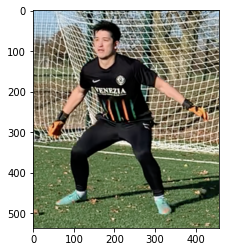

In [ ]:
image = importImage('6.png')
plt.imshow(image)

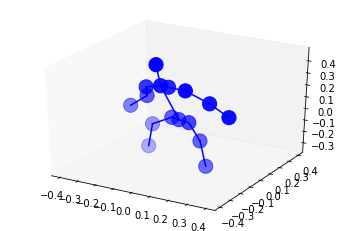

In [ ]:
pred, pred_3d = getPose(image, input_h, input_w, output_h, output_w, mean, std)
#Plot 3D pose
debugger = Debugger()
debugger.add_img(image)
debugger.add_point_2d(pred, (255, 0, 0))
debugger.add_point_3d(pred_3d, 'b')
#debugger.show_all_imgs(pause=False)
debugger.show_3d()

## Create Amateur Body Pose Dataset (1v1s)


In [ ]:
#Key variables for image
input_h, input_w = 256, 256
output_h, output_w = 64, 64
mean = np.array([0.485, 0.456, 0.406], np.float32).reshape(1, 1, 3)
std = np.array([0.229, 0.224, 0.225], np.float32).reshape(1, 1, 3)

#Create dataframes
pred_df = pd.DataFrame()
pred_3d_df = pd.DataFrame()
path = 'drive/MyDrive/LearningFromThePros/amateur_1v1/'

In [ ]:
#Extract body pose for each image in path
for n in range(len(os.listdir(path))):
  image = importImage(path + str(n) + '.png')
  pred, pred_3d = getPose(image, input_h, input_w, output_h, output_w, mean, std)
  pred_flat = pd.Series(pred.flatten())
  pred_3d_flat = pd.Series(pred_3d.flatten())
  pred_df = pred_df.append(pred_flat, ignore_index=True)
  pred_3d_df = pred_3d_df.append(pred_3d_flat, ignore_index=True)

In [ ]:
#Save combined dataframes to google drive
pred_df.to_csv('drive/MyDrive/LearningFromThePros/amateur_2d_1v1s.csv')
pred_3d_df.to_csv('drive/MyDrive/LearningFromThePros/amateur_3d_1v1s.csv')

## Create Body Pose Dataset (19/20 and 20/21)
Firstly, start with the prem_19_20_20_21 images. 2D pose predictions are stored in pred_df. 3D pose predictions are stored in pred_3d_df. Final dataset is stored in Google Drive as 'pose_2d_19_20_20_21.csv' and 'pose_3d_19_20_20_21.csv'.

In [ ]:
#Key variables for image
input_h, input_w = 256, 256
output_h, output_w = 64, 64
mean = np.array([0.485, 0.456, 0.406], np.float32).reshape(1, 1, 3)
std = np.array([0.229, 0.224, 0.225], np.float32).reshape(1, 1, 3)

#Create dataframes
pred_df = pd.DataFrame()
pred_3d_df = pd.DataFrame()
path = 'drive/MyDrive/GKBodyPose/PenaltyData/prem_19_20_20_21/'

In [ ]:
#Extract body pose for each image in path
for n in range(len(os.listdir(path))):
  image = importImage(path + 'f' + str(n) + '.png')
  pred, pred_3d = getPose(image, input_h, input_w, output_h, output_w, mean, std)
  pred_flat = pd.Series(pred.flatten())
  pred_3d_flat = pd.Series(pred_3d.flatten())
  pred_df = pred_df.append(pred_flat, ignore_index=True)
  pred_3d_df = pred_3d_df.append(pred_3d_flat, ignore_index=True)
  print('Done ' + str(n))

In [ ]:
fbref_df = pd.read_csv('drive/MyDrive/GKBodyPose/PenaltyData/prem_pens_192021_df.csv', index_col=0)

In [ ]:
#Create the combined dataset
pose_2d_df = fbref_df.merge(pred_df, how='left', left_index=True, right_index=True)
pose_3d_df = fbref_df.merge(pred_3d_df, how='left', left_index=True, right_index=True)

In [ ]:
#Save combined dataframes to google drive
pose_2d_df.to_csv('drive/MyDrive/GKBodyPose/PenaltyData/pose_2d_19_20_20_21.csv')
pose_3d_df.to_csv('drive/MyDrive/GKBodyPose/PenaltyData/pose_3d_19_20_20_21.csv')

## Create Body Pose Dataset (17/18 and 18/19)
Firstly, start with the prem_17_18_18_19 images. 2D pose predictions are stored in pred_df. 3D pose predictions are stored in pred_3d_df. Final dataset is stored in Google Drive as 'pose_2d_17_18_18_19.csv' and 'pose_3d_17_18_18_19.csv'.

In [ ]:
#Key variables for image
input_h, input_w = 256, 256
output_h, output_w = 64, 64
mean = np.array([0.485, 0.456, 0.406], np.float32).reshape(1, 1, 3)
std = np.array([0.229, 0.224, 0.225], np.float32).reshape(1, 1, 3)

#Create dataframes
pred_df = pd.DataFrame()
pred_3d_df = pd.DataFrame()
path = 'drive/MyDrive/GKBodyPose/PenaltyData/prem_17_18_18_19/'

In [ ]:
#Extract body pose for each image in path
for img in os.listdir(path):
  image = importImage(path + img)
  pred, pred_3d = getPose(image, input_h, input_w, output_h, output_w, mean, std)
  pred_flat = pd.Series(pred.flatten())
  pred_3d_flat = pd.Series(pred_3d.flatten())
  #Add image ID to final column of each series
  img_id = int(re.findall('\d+', img )[0])
  pred_flat[len(pred_flat)] = img_id
  pred_3d_flat[len(pred_3d_flat)] = img_id
  pred_df = pred_df.append(pred_flat, ignore_index=True)
  pred_3d_df = pred_3d_df.append(pred_3d_flat, ignore_index=True)
  print('Done ' + img)

In [ ]:
sb_df = pd.read_csv('drive/MyDrive/GKBodyPose/PenaltyData/prem_pens_df.csv', index_col=0)

In [ ]:
#Create the combined dataset
pose_2d_df = sb_df.merge(pred_df, how='left', left_index=True, right_on=32)
pose_3d_df = sb_df.merge(pred_3d_df, how='left', left_index=True, right_on=48)

In [ ]:
pose_2d_df = pose_2d_df.reset_index(drop=True)
pose_2d_df.drop(columns=[32], inplace=True)
pose_3d_df = pose_3d_df.reset_index(drop=True)
pose_3d_df.drop(columns=[48], inplace=True)

In [ ]:
#Save combined dataframes to google drive
pose_2d_df.to_csv('drive/MyDrive/GKBodyPose/PenaltyData/pose_2d_17_18_18_19.csv')
pose_3d_df.to_csv('drive/MyDrive/GKBodyPose/PenaltyData/pose_3d_17_18_18_19.csv')

# Create One v One Data

In [ ]:
def get1v1KeypointsDF(folder = 'set'):
  #Key variables for image
  input_h, input_w = 256, 256
  output_h, output_w = 64, 64
  mean = np.array([0.485, 0.456, 0.406], np.float32).reshape(1, 1, 3)
  std = np.array([0.229, 0.224, 0.225], np.float32).reshape(1, 1, 3)

  #Create dataframes
  pred_df = pd.DataFrame()
  pred_3d_df = pd.DataFrame()
  path = 'drive/MyDrive/GKBodyPose/OnevOne/' + folder + '/'
  file_list = os.listdir(path)

  i = 1
  num_files = len(file_list)
  #Extract body pose for each image in path
  for file_name in file_list:
    image = importImage(path + file_name)
    pred, pred_3d = getPose(image, input_h, input_w, output_h, output_w, mean, std)
    pred_flat = pd.Series(pred.flatten())
    pred_3d_flat = pd.Series(pred_3d.flatten())
    pred_df = pred_df.append(pred_flat, ignore_index=True)
    pred_3d_df = pred_3d_df.append(pred_3d_flat, ignore_index=True)
    print('Done ' + str(i) + ' / ' + str(num_files))
    i += 1

  #Add photo names to dataframes
  pred_df['file'] = file_list
  pred_3d_df['file'] = file_list
  return pred_df, pred_3d_df

In [ ]:
#Get keypoints dataframe for set images
pred_df, pred_3d_df = get1v1KeypointsDF(folder = 'set')

In [ ]:
#Save combined dataframes to google drive
pred_df.to_csv('drive/MyDrive/GKBodyPose/OnevOne/set_2d.csv')
pred_3d_df.to_csv('drive/MyDrive/GKBodyPose/OnevOne/set_3d.csv')

In [ ]:
#Get keypoints dataframe for save images
pred_df, pred_3d_df = get1v1KeypointsDF(folder = 'save')

In [ ]:
#Save combined dataframes to google drive
pred_df.to_csv('drive/MyDrive/GKBodyPose/OnevOne/save_2d.csv')
pred_3d_df.to_csv('drive/MyDrive/GKBodyPose/OnevOne/save_3d.csv')